In [1]:
############### Import packages
import os, numpy as np, pandas as pd, time, glob, re, math, statsmodels.api as sm, patsy as ps, matplotlib.pyplot as plt
from tqdm import tqdm
from time import process_time
from datetime import datetime
from datetime import date
from openpyxl import load_workbook
from patsy import dmatrices

############### Set working directory to parent directory
if os.getcwd() != 'F:\\github\\narrative_conservatism\\code':
    os.chdir('F:\\github\\narrative_conservatism\\code')

############### Set pandas column printing constraint
pd.set_option('display.max_columns', None)

In [2]:
#############################################################################################
####### Merge IBES annual data (oen-year forecast) with CRSP_COMP_EDGAR quarterly data ######
#############################################################################################

########### Read IBES raw data file
ibes_cols = ['CUSIP', 'VALUE', 'FPEDATS', 'ACTUAL', 'FPI', 'ANNDATS']
ibes = pd.read_csv('..\\filings\\ibes.csv', usecols = ibes_cols)
print('number of cusip-fpedats-analyst: ' + str(ibes.shape[0]))

### Reorder and rename IBES columns
ibes = ibes.rename(columns={'CUSIP': 'cusip', 'VALUE': 'value', 'FPEDATS': 'fpedats', 'ACTUAL': 'actual', 'FPI': 'fpi', 'ANNDATS': 'anndats'})
ibes = ibes[['cusip', 'fpedats', 'anndats', 'fpi', 'value', 'actual']]

### correct fpedats format
ibes['fpedats'] = ibes['fpedats'].str.replace('jan','01')
ibes['fpedats'] = ibes['fpedats'].str.replace('JAN','01')
ibes['fpedats'] = ibes['fpedats'].str.replace('feb','02')
ibes['fpedats'] = ibes['fpedats'].str.replace('FEB','02')
ibes['fpedats'] = ibes['fpedats'].str.replace('mar','03')
ibes['fpedats'] = ibes['fpedats'].str.replace('MAR','03')
ibes['fpedats'] = ibes['fpedats'].str.replace('apr','04')
ibes['fpedats'] = ibes['fpedats'].str.replace('APR','04')
ibes['fpedats'] = ibes['fpedats'].str.replace('may','05')
ibes['fpedats'] = ibes['fpedats'].str.replace('MAY','05')
ibes['fpedats'] = ibes['fpedats'].str.replace('jun','06')
ibes['fpedats'] = ibes['fpedats'].str.replace('JUN','06')
ibes['fpedats'] = ibes['fpedats'].str.replace('jul','07')
ibes['fpedats'] = ibes['fpedats'].str.replace('JUL','07')
ibes['fpedats'] = ibes['fpedats'].str.replace('aug','08')
ibes['fpedats'] = ibes['fpedats'].str.replace('AUG','08')
ibes['fpedats'] = ibes['fpedats'].str.replace('sep','09')
ibes['fpedats'] = ibes['fpedats'].str.replace('SEP','09')
ibes['fpedats'] = ibes['fpedats'].str.replace('oct','10')
ibes['fpedats'] = ibes['fpedats'].str.replace('OCT','10')
ibes['fpedats'] = ibes['fpedats'].str.replace('nov','11')
ibes['fpedats'] = ibes['fpedats'].str.replace('NOV','11')
ibes['fpedats'] = ibes['fpedats'].str.replace('dec','12')
ibes['fpedats'] = ibes['fpedats'].str.replace('DEC','12')
ibes['fpedats'] = pd.to_datetime(ibes['fpedats'], format='%d%m%Y')

### correct fpedats format
ibes['anndats'] = ibes['anndats'].str.replace('jan','01')
ibes['anndats'] = ibes['anndats'].str.replace('JAN','01')
ibes['anndats'] = ibes['anndats'].str.replace('feb','02')
ibes['anndats'] = ibes['anndats'].str.replace('FEB','02')
ibes['anndats'] = ibes['anndats'].str.replace('mar','03')
ibes['anndats'] = ibes['anndats'].str.replace('MAR','03')
ibes['anndats'] = ibes['anndats'].str.replace('apr','04')
ibes['anndats'] = ibes['anndats'].str.replace('APR','04')
ibes['anndats'] = ibes['anndats'].str.replace('may','05')
ibes['anndats'] = ibes['anndats'].str.replace('MAY','05')
ibes['anndats'] = ibes['anndats'].str.replace('jun','06')
ibes['anndats'] = ibes['anndats'].str.replace('JUN','06')
ibes['anndats'] = ibes['anndats'].str.replace('jul','07')
ibes['anndats'] = ibes['anndats'].str.replace('JUL','07')
ibes['anndats'] = ibes['anndats'].str.replace('aug','08')
ibes['anndats'] = ibes['anndats'].str.replace('AUG','08')
ibes['anndats'] = ibes['anndats'].str.replace('sep','09')
ibes['anndats'] = ibes['anndats'].str.replace('SEP','09')
ibes['anndats'] = ibes['anndats'].str.replace('oct','10')
ibes['anndats'] = ibes['anndats'].str.replace('OCT','10')
ibes['anndats'] = ibes['anndats'].str.replace('nov','11')
ibes['anndats'] = ibes['anndats'].str.replace('NOV','11')
ibes['anndats'] = ibes['anndats'].str.replace('dec','12')
ibes['anndats'] = ibes['anndats'].str.replace('DEC','12')
ibes['anndats'] = pd.to_datetime(ibes['anndats'], format='%d%m%Y')
ibes['date_key'] = pd.DatetimeIndex(ibes['anndats']).year

### Delete missing cusip8
del_cusip = ibes[ibes['cusip'].isnull()].shape[0]
ibes = ibes[ibes['cusip'].isnull() == False]
print('number of obs. that contain missing cusip: ' + str(del_cusip))

### aggregate by cusip-anndats and get LT_growth from ibes raw data
ibes_LT = ibes[ibes['fpi'] == 0].groupby(['cusip', 'date_key'])['value'].median().to_frame().rename(columns={'value': 'LT_growth'})

del_actual = ibes[ibes['actual'].isnull()].shape[0]
ibes = ibes[ibes['actual'].isnull() == False]
print('number of obs. that contain missing actual: ' + str(del_actual))

### aggregate by cusip-fpedats and get actual, median, afe and consensus from ibes raw data
ibes_css = ibes[ibes['fpi'] == 1].groupby(['cusip', 'fpedats'])['actual'].median().to_frame()
ibes_css['median'] = ibes[ibes['fpi'] == 1].groupby(['cusip', 'fpedats'])['value'].median().to_frame()
ibes_css['afe'] = ibes_css['actual'] - ibes_css['median']
ibes_css['leap_consensus'] = ibes[ibes['fpi'] == 2].groupby(['cusip', 'fpedats'])['value'].mean().to_frame()

# ### make a consensus forecast dataset by cusip-fpedats
ibes = ibes.loc[ibes.duplicated(subset=['cusip', 'fpedats']) == False, ['cusip','fpedats']]
ibes = ibes.join(ibes_css, on=['cusip', 'fpedats'])

### create merge date_key - keep %y only
ibes['date_key'] = ibes['fpedats'].astype(str).str[:-6].astype(int)
ibes = ibes.join(ibes_LT, on=['cusip', 'date_key'])

print('number of cusip-fpedats, dropping missing cusip and actual: ' + str(ibes.shape[0]))

number of cusip-fpedats-analyst: 10604033
number of obs. that contain missing cusip: 60888
number of obs. that contain missing actual: 1890129
number of cusip-fpedats, dropping missing cusip and actual: 152000


In [3]:
##################### Read EDGAR_CRSP_COMP and creat merge date_key
crsp_comp_edgar = pd.read_csv('..\\filings\\crsp_comp_edgar_8-K.csv')
crsp_comp_edgar['date_key'] = crsp_comp_edgar['fyearq'].astype(int)

##################### Inner merge EDGAR_CRSP_COMP and IBES, key not unique in both datasets
crsp_comp_edgar_ibes = pd.merge(crsp_comp_edgar, ibes, on = ['cusip', 'date_key'], how='inner', validate = 'm:m')
print('number of cusip-date after merging: ' + str(crsp_comp_edgar_ibes.shape[0]))

crsp_comp_edgar_ibes.sort_values(by = ['cusip', 'cmonth'])

number of cusip-date after merging: 87041


,cusip,date_crsp,cik,gvkey,rp,name,SIC,fd,cmonth,fyearq,atq,lag_atq,ceqq,prccq,lag_ceqq,lag_cshoq,lag_prccq,SG,LAG_SG,sstky,xrdq,intanq,LEV,RET,DRET,STD_DRET,STD_EARN,EARN,BN,n8k,nitem,nexhibit,ngraph,nw,nvocab,n_neg,n_pos,n_negation,tone,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_1.01,item_1.02,item_1.03,item_1.04,item_2.01,item_2.02,item_2.03,item_2.04,item_2.05,item_2.06,item_3.01,item_3.02,item_3.03,item_4.01,item_4.02,item_5.01,item_5.02,item_5.03,item_5.04,item_5.05,item_5.06,item_5.07,item_5.08,item_6.01,item_6.02,item_6.03,item_6.04,item_6.05,item_7.01,item_8.01,item_9.01,NW,TONE,TLAG,RLAG,SIZE,MTB,lag_date_crsp,date_key,fpedats,actual,median,afe,leap_consensus,LT_growth
39966,00030710,2015-06-10,1606180,178698.0,2015-06-16,"AAC Holdings, Inc.",8060,2015-06-19,201506,2015.0,210.265,188.983,109.824,43.560,101.145,21.781,30.58,0.052129,0.029934,0.000,0.000,28.972,0.402512,0.096483,0.158494,0.045336,0.009461,0.029394,0,1,2.0,1.0,0.0,448,190,4,1,0,-0.006696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.107023,-6.696429,9,6,6.501384,6.585229,2014-12-10,2015,2015-12-31,0.97,0.800,0.170,0.635000,NaN
39967,00030710,2015-08-10,1606180,178698.0,2015-08-10,"AAC Holdings, Inc.",8060,2015-08-10,201508,2015.0,290.911,210.265,139.720,22.250,109.824,21.816,43.56,0.012334,0.052129,0.000,0.000,112.594,0.360821,0.045946,0.155929,0.094644,0.009461,0.011661,0,2,5.0,4.0,25.0,753,359,3,2,0,-0.001328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,6.625392,-1.328021,0,0,6.856783,8.652981,2015-06-10,2015,2015-12-31,0.97,0.800,0.170,0.635000,NaN
39968,00030710,2015-08-24,1606180,178698.0,2015-08-24,"AAC Holdings, Inc.",8060,2015-08-26,201508,2015.0,290.911,210.265,139.720,22.250,109.824,21.816,43.56,0.012334,0.052129,0.000,0.000,112.594,0.360821,-0.043702,-0.186945,0.094644,0.009461,0.011661,1,1,1.0,0.0,0.0,429,219,32,2,0,-0.069930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.063785,-69.930070,2,0,6.856783,8.652981,2015-08-10,2015,2015-12-31,0.97,0.800,0.170,0.635000,NaN
39969,00030710,2016-01-25,1606180,178698.0,2016-01-26,"AAC Holdings, Inc.",8060,2016-01-27,201601,2016.0,314.995,316.049,145.136,19.790,141.654,22.814,19.06,0.022432,0.002879,0.000,0.000,117.858,0.459236,0.116157,0.129585,0.055064,0.011384,0.001854,0,1,3.0,2.0,22.0,354,169,1,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.872118,0.000000,2,1,6.074966,3.069697,2015-08-24,2016,2016-12-31,0.71,0.895,-0.185,1.099355,NaN
39970,00030710,2016-01-29,1606180,178698.0,2016-02-22,"AAC Holdings, Inc.",8060,2016-02-26,201602,2016.0,314.995,316.049,145.136,19.790,141.654,22.814,19.06,0.022432,0.002879,0.000,0.000,117.858,0.459236,0.016831,0.141521,0.055064,0.011384,0.001854,0,1,2.0,1.0,0.0,698,243,0,5,0,0.007163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.549651,7.163324,28,24,6.074966,3.069697,2016-01-25,2016,2016-12-31,0.71,0.895,-0.185,1.099355,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40631,Y9530810,2018-12-27,1631574,26340.0,2019-01-03,Wave Life Sciences Ltd

In [4]:
########################################################################################
############ Merge CRSP_COMP_EDGAR_IBES data with SEG data #############################
########################################################################################

########### Read SEG raw data file
seg_cols = ['gvkey', 'stype', 'sid', 'datadate', 'snms', 'cusip', 'cik']
seg = pd.read_csv('..\\filings\\compustat_seg.csv', usecols = seg_cols)
print('number of gvkey_datadate_sid: ' + str(seg.shape[0]))

### Reorder and rename IBES columns
seg = seg[['gvkey', 'cik', 'cusip', 'datadate', 'stype', 'sid', 'snms']]
seg = seg.rename(columns={'datadate': 'date_comp'})

### parse date_comp format
seg['date_comp'] = pd.to_datetime(seg['date_comp'], format='%Y%m%d')

### aggregate by gvkey-date_comp-stype and get count of sid
seg_count = seg.groupby(['gvkey', 'date_comp', 'stype'])['sid'].count().to_frame()

### make a segment dataset by gvkey-date_comp-stype
seg = seg.loc[seg.duplicated(subset=['gvkey', 'date_comp', 'stype']) == False, ['gvkey', 'date_comp', 'stype']]
seg = seg.join(seg_count, on=['gvkey', 'date_comp', 'stype'])
seg_bus = seg[seg['stype']=='BUSSEG']
seg_bus = seg_bus.drop(columns=['stype'])
seg_bus = seg_bus.rename(columns={'sid': 'nseg_bus'})
seg_geo = seg[seg['stype']=='GEOSEG']
seg_geo = seg_geo.drop(columns=['stype'])
seg_geo = seg_geo.rename(columns={'sid': 'nseg_geo'})
seg = seg.loc[seg.duplicated(subset=['gvkey', 'date_comp']) == False, ['gvkey', 'date_comp']]
seg = pd.merge(seg, seg_bus, on = ['gvkey', 'date_comp'], how='left', validate = '1:1')
seg = pd.merge(seg, seg_geo, on = ['gvkey', 'date_comp'], how='left', validate = '1:1')
seg = seg.sort_values(by=['gvkey', 'date_comp'])
seg.loc[seg['nseg_geo'].isnull(), 'nseg_geo'] = 1
seg.loc[seg['nseg_bus'].isnull(), 'nseg_bus'] = 1
seg['nseg_bus'] = seg['nseg_bus'].astype(int)
seg['nseg_geo'] = seg['nseg_geo'].astype(int)

### create merge date_key - %y only
seg['date_key'] = seg['date_comp'].astype(str).str[:-6].astype(int)
seg = seg.drop(columns=['date_comp'])

print('number of gvkey-datadate in SEGMENT data: ' + str(seg.shape[0]))

number of gvkey_datadate_sid: 452653
number of gvkey-datadate in SEGMENT data: 50876


In [5]:
##################### left merge EDGAR_CRSP_COMP_IBES and SEG, key not unique in both datasets
crsp_comp_edgar_ibes_seg = pd.merge(crsp_comp_edgar_ibes, seg, on = ['gvkey', 'date_key'], how='left', validate = 'm:m')
# crsp_comp_edgar_ibes_seg_inner = pd.merge(crsp_comp_edgar_ibes, seg, on = ['gvkey', 'date_key'], how='inner', validate = 'm:m')
# print('Number of gvkey-quarter obs. after merging, inner: '+ str(crsp_comp_edgar_ibes_seg_inner.shape[0]))

##################### Fill missing segments in crsp_comp_edgar_ibes_seg_left with 1
crsp_comp_edgar_ibes_seg.loc[crsp_comp_edgar_ibes_seg['nseg_bus'].isnull(), 'nseg_bus'] = 1
crsp_comp_edgar_ibes_seg.loc[crsp_comp_edgar_ibes_seg['nseg_geo'].isnull(), 'nseg_geo'] = 1

####### Drop duplicated gykey-cquarter
crsp_comp_edgar_ibes_seg = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg.duplicated(subset=['gvkey', 'cmonth']) == False]
crsp_comp_edgar_ibes_seg = crsp_comp_edgar_ibes_seg.drop(columns=['date_key', 'fpedats', 'actual', 'median'])
print('Number of gvkey-quarter obs. after merging, left: '+ str(crsp_comp_edgar_ibes_seg.shape[0]))

Number of gvkey-quarter obs. after merging, left: 83464


In [6]:
########################################################################################
############################### Variable Creation ######################################
########################################################################################

################### CRSP_COMP_EDGAR_IBES_SEG_LEFT ######################################

######## BUSSEG: log(1 + number of business segments), or 1 if item is missing from Compustat; and
######## GEOSEG: log(1 + number of geographic segments), or 1 if item is missing from Compustat.
crsp_comp_edgar_ibes_seg['BUSSEG'] = np.log(1 + crsp_comp_edgar_ibes_seg['nseg_bus'])
crsp_comp_edgar_ibes_seg['GEOSEG'] = np.log(1 + crsp_comp_edgar_ibes_seg['nseg_geo'])

######## AFE, analyst forecast error, \
######## defined as I/B/E/S earnings per share minus the median of the most recent analysts’ forecasts, \
######## deflated by stock price per share at the end of the fiscal quarter
crsp_comp_edgar_ibes_seg['AFE'] = crsp_comp_edgar_ibes_seg['afe']/crsp_comp_edgar_ibes_seg['prccq']

######## AF, analyst consensus forecast for one-year-ahead earnings per share, scaled by stock price per share at the end of the fiscal quarter
crsp_comp_edgar_ibes_seg['AF'] = crsp_comp_edgar_ibes_seg['leap_consensus']/crsp_comp_edgar_ibes_seg['prccq']

In [7]:
########################################################################################
########################## Variable Screening ##########################################
########################################################################################

########## Drop files (firm-quarter) that have positive/negative infinity DEARN
# del_DEARN = crsp_comp_edgar_ibes_seg[(crsp_comp_edgar_ibes_seg['DEARN']==np.inf) | (crsp_comp_edgar_ibes_seg['DEARN']==-np.inf)].shape[0]
# crsp_comp_edgar_ibes_seg = crsp_comp_edgar_ibes_seg[(crsp_comp_edgar_ibes_seg['DEARN']!=np.inf) & (crsp_comp_edgar_ibes_seg['DEARN']!=-np.inf)]
# print('number of files that have positive/negative infinity DEARN: ' + str(del_DEARN))

### Drop missing AF
# del_AF = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg['AF'].isnull()].shape[0]
# crsp_comp_edgar_ibes_seg = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg['AF'].isnull() == False]
# print('number of obs. that contain missing AF: ' + str(del_AF))

# ### Drop missing AFE
# del_AFE = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg['AFE'].isnull()].shape[0]
# crsp_comp_edgar_ibes_seg = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg['AFE'].isnull() == False]
# print('number of obs. that contain missing AFE: ' + str(del_AFE))

# ### Drop missing EARN
# del_EARN = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg['EARN'].isnull()].shape[0]
# crsp_comp_edgar_ibes_seg = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg['EARN'].isnull() == False]
# print('number of obs. that contain missing EARN: ' + str(del_EARN))

# ### Drop missing STD_EARN
# del_STD_EARN = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg['STD_EARN'].isnull()].shape[0]
# crsp_comp_edgar_ibes_seg = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg['STD_EARN'].isnull() == False]
# print('number of obs. that contain missing STD_EARN: ' + str(del_STD_EARN))

# ### Drop missing EARN
# del_DEARN = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg['DEARN'].isnull()].shape[0]
# crsp_comp_edgar_ibes_seg = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg['DEARN'].isnull() == False]
# print('number of obs. that contain missing DEARN: ' + str(del_DEARN))

############## Winsorize ##############################
###### Define a function that winsorize a variable at 1% and 99% 
def winsorize (df, colnames):
    for col in colnames:
        varq01 = df[col].quantile(.01)
        varq99 = df[col].quantile(.99)
        df[col] = df[col].clip(varq01, varq99)
    return df

############## Winsorize TABLE 1 (line 1) and TABLE 4 (line 2) variables
crsp_comp_edgar_ibes_seg = winsorize(crsp_comp_edgar_ibes_seg, \
                                          ['SIZE', 'MTB', 'LEV', 'EARN', 'STD_DRET', 'STD_EARN', 'AF', 'AFE', 'BUSSEG','GEOSEG','EARN'])

############## Inspect sample size after variable screening
print('Number of firm-quarters after variable screening: ' + str(crsp_comp_edgar_ibes_seg.shape[0]))

Number of firm-quarters after variable screening: 83464


In [8]:
# ######## Create ABTONE: residual from TONE regression 
# y, X = ps.dmatrices('TONE ~ 1 + EARN + RET + SIZE + MTB + STD_RET + STD_EARN + AGE + BUSSEG + GEOSEG + LOSS + DEARN + AFE + AF', \
#                     data = crsp_comp_edgar_ibes_seg, return_type = 'dataframe')
# model = sm.OLS(y, X)
# res = model.fit()
# # res.summary()
# crsp_comp_edgar_ibes_seg['ABTONE'] = res.resid

# ######## Create abtone for REPLICATION: residual from tone regression 
# y, X = ps.dmatrices('tone ~ 1 + EARN + RET + SIZE + MTB + STD_RET + STD_EARN + AGE + BUSSEG + GEOSEG + LOSS + DEARN + AFE + AF', \
#                     data = crsp_comp_edgar_ibes_seg, return_type = 'dataframe')
# model = sm.OLS(y, X)
# res = model.fit()
# # res.summary()
# crsp_comp_edgar_ibes_seg['abtone'] = res.resid

############## Save merged CRSP_COMP_EDGAR_IBES_SEG to csv file
crsp_comp_edgar_ibes_seg.to_csv('..\\filings\\crsp_comp_edgar_ibes_seg_8-K.csv', index = 0)

crsp_comp_edgar_ibes_seg

,cusip,date_crsp,cik,gvkey,rp,name,SIC,fd,cmonth,fyearq,atq,lag_atq,ceqq,prccq,lag_ceqq,lag_cshoq,lag_prccq,SG,LAG_SG,sstky,xrdq,intanq,LEV,RET,DRET,STD_DRET,STD_EARN,EARN,BN,n8k,nitem,nexhibit,ngraph,nw,nvocab,n_neg,n_pos,n_negation,tone,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_1.01,item_1.02,item_1.03,item_1.04,item_2.01,item_2.02,item_2.03,item_2.04,item_2.05,item_2.06,item_3.01,item_3.02,item_3.03,item_4.01,item_4.02,item_5.01,item_5.02,item_5.03,item_5.04,item_5.05,item_5.06,item_5.07,item_5.08,item_6.01,item_6.02,item_6.03,item_6.04,item_6.05,item_7.01,item_8.01,item_9.01,NW,TONE,TLAG,RLAG,SIZE,MTB,lag_date_crsp,afe,leap_consensus,LT_growth,nseg_bus,nseg_geo,BUSSEG,GEOSEG,AFE,AF
0,59100210,1999-04-15,1000015,61641.0,1999-04-15,META GROUP INC,8700,1999-04-15,199904,1999.0,91.403,109.766,54.284,15.375,74.721,10.932,15.375,0.043828,-0.023905,1.337,NaN,33.872,0.000000,-0.330093,-0.468600,0.105088,0.007034,0.018658,1,1,2.0,1.0,0.0,793,391,6,6,0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.677083,0.000000,0,0,5.124437,2.249428,NaN,0.030,0.910870,27.5,1.0,1.0,0.693147,0.693147,0.001951,0.059244
1,59100210,2000-12-06,1000015,61641.0,2000-12-11,META GROUP INC,8700,2000-12-13,200012,2001.0,135.015,142.577,52.786,2.190,66.053,12.830,2.000,0.021946,-0.029142,4.916,NaN,33.872,0.153601,-0.059721,-0.200798,0.110764,0.041664,-0.091361,1,1,2.0,1.0,0.0,276,153,0,0,0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.624018,0.000000,7,5,3.244933,0.388476,1999-04-15,-0.105,1.146667,13.7,1.0,1.0,0.693147,0.693147,-0.047945,0.416140
2,59100210,2001-04-05,1000015,61641.0,2001-04-05,META GROUP INC,8700,2001-04-10,200104,2001.0,135.015,142.577,52.786,2.190,66.053,12.830,2.000,0.021946,-0.029142,4.916,NaN,33.872,0.153601,0.216629,0.472604,0.110764,0.041664,-0.091361,0,1,2.0,1.0,0.0,201,123,1,0,0,-0.004975,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.308268,-4.975124,5,0,3.244933,0.388476,2000-12-06,-0.105,1.146667,13.7,1.0,1.0,0.693147,0.693147,-0.047945,0.416140
3,59100210,2001-05-22,1000015,61641.0,2001-06-15,META GROUP INC,8700,2001-06-20,200106,2001.0,135.015,142.577,52.786,2.190,66.053,12.830,2.000,0.021946,-0.029142,4.916,NaN,33.872,0.153601,-0.042545,-0.248976,0.110764,0.041664,-0.091361,1,1,2.0,0.0,0.0,1009,433,11,15,1,0.002973,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.917706,2.973241,29,24,3.244933,0.388476,2001-04-05,-0.105,1.146667,13.7,1.0,1.0,0.693147,0.693147,-0.047945,0.416140
4,59100210,2002-02-21,1000015,61641.0,2002-02-21,META GROUP INC,8700,2002-02-28,200202,2002.0,78.733,119.642,11.062,2.098,52.202,12.844,2.250,-0.045330,0.015237,0.507,NaN,12.308,0.062629,-0.093554,-0.304440,0.096838,0.071838,-0.170107,1,1,2.0,1.0,0.0,201,119,1,1,0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.308268,0.000000,7,0,3.363807,0.553599,2001-05-22,NaN,NaN,NaN,1.0,1.0,0.693147,0.693147,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87055,06780610,2018-05-04,9984,2049.0,2018-05-04,BARNES GROUP IN

In [9]:
# ####################################################################################################################
# ############# Create COMP_DA: if not replicating TABLE 4, DO NOT run because cause large sample reduction ##########
# ####################################################################################################################

# ### Drop missing or infinite LAG_TA_REV, DSAR and PPE
# crsp_comp_edgar_ibes_seg = crsp_comp_edgar_ibes_seg.loc[(crsp_comp_edgar_ibes_seg['LAG_TA_REV'] != np.inf) & \
#                                                         (crsp_comp_edgar_ibes_seg['LAG_TA_REV'].isnull() == False) & \
#                                                         (crsp_comp_edgar_ibes_seg['LAG_TA_REV'] != -np.inf)]
# crsp_comp_edgar_ibes_seg = crsp_comp_edgar_ibes_seg.loc[(crsp_comp_edgar_ibes_seg['DSAR'] != np.inf) & \
#                                                         (crsp_comp_edgar_ibes_seg['DSAR'].isnull() == False) & \
#                                                         (crsp_comp_edgar_ibes_seg['DSAR'] != -np.inf)]
# crsp_comp_edgar_ibes_seg = crsp_comp_edgar_ibes_seg.loc[(crsp_comp_edgar_ibes_seg['PPE'] != np.inf) & \
#                                                         (crsp_comp_edgar_ibes_seg['PPE'].isnull() == False) & \
#                                                         (crsp_comp_edgar_ibes_seg['PPE'] != -np.inf)]
# print('number of obs. after deleting missing or infinite LAG_TA_REV, DSAR and PPE: ' + str(crsp_comp_edgar_ibes_seg.shape[0]))

# ############## Winsorize DA variables
# crsp_comp_edgar_ibes_seg = winsorize(crsp_comp_edgar_ibes_seg, ['TACC', 'LAG_TA_REV', 'DSAR', 'PPE'])

# ######## Create DA: residual from TACC regression by each two-digit SIC-year
# def TACC_reg(data):
#     try:
#         y, X = ps.dmatrices('TACC ~ 1 + LAG_TA_REV + DSAR + PPE', data = data, return_type = 'dataframe')
#         model = sm.OLS(y, X)
#         res = model.fit()
#         data['DA'] = res.resid
#         return data
#     except:
#         pass

# crsp_comp_edgar_ibes_seg1 = crsp_comp_edgar_ibes_seg.groupby(['SIC2','fyearq']).apply(TACC_reg)
# # comp_DA['DA'].describe()

# ####### Join DA to COMP
# crsp_comp_edgar_ibes_seg = pd.merge(crsp_comp_edgar_ibes_seg, crsp_comp_edgar_ibes_seg1[['cik', 'rp', 'DA']], on = ['cik', 'rp'], how='left', validate = '1:1')

# crsp_comp_edgar_ibes_seg

# ############## Dropping missing DA to replicate Huang et al. 2014 TABLE 4, \
# del_DA = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg['DA'].isnull()].shape[0]
# crsp_comp_edgar_ibes_seg = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg['DA'].isnull() == False]
# print('number of obs. that contain missing DA: ' + str(del_DA))

# ############## Inspect sample size after variable screening
# print('Number of firm-quarters after dropping missing DA: ' + str(crsp_comp_edgar_ibes_seg.shape[0]))

# ############## Save merged ID_CRSP_COMP_TEXT to csv file
# crsp_comp_edgar_ibes_seg.to_csv('..\\filings\\crsp_comp_edgar_ibes_seg_DA_10-Q.csv', index = 0)

In [9]:
########################################################################################
########### Table 2 - Panel A: Summary Statistics and Correlation Matrix ###############
########################################################################################

############# Table 2 Panel A: Summary statistics for selected variables
######### Variable groups:
# 1st line: textual variables, generally consistent with LM's summary statistics
# 2nd line: fundamental variables (main)
# 3rd line: abtone
selected_vars = crsp_comp_edgar_ibes_seg[['nw', 'TONE','TLAG', 'n8k', 'nitem', 'nexhibit', 'ngraph', \
                                          'RET', 'DRET', 'BN', 'SIZE', 'MTB', 'LEV', \
                                          'AF', 'AFE', 'BUSSEG','GEOSEG', 'EARN', 'STD_EARN', 'STD_DRET'
                                        # 'DA', 'LOSS', 'DEARN'
                                        ]]

T2PB = selected_vars.describe().transpose() 

############ count number of unique firms
print('Number of unique firms in final 10-Q sample: ' + str(crsp_comp_edgar_ibes_seg['cik'].unique().shape[0]))

############# Summary statistics for all raw and processed variables
full_summary = crsp_comp_edgar_ibes_seg.describe().transpose()

############# Save T2PB
table_path = '..\\output\\Tables.xlsx'
if os.path.exists(table_path) == True:
    book = load_workbook(table_path)
    writer = pd.ExcelWriter(table_path, engine = 'openpyxl')
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

    T2PB.to_excel(writer, sheet_name='T2PB_raw', float_format="%.4f")

    writer.save()
    writer.close()
    
else:
    T2PB.to_excel(table_path, sheet_name='T2PB_raw', float_format="%.4f")

T2PB

Number of unique firms in final 10-Q sample: 6477


,count,mean,std,min,25%,50%,75%,max
nw,83464.0,1206.607531,6014.907457,133.000000,260.000000,346.000000,566.000000,264704.000000
TONE,83464.0,-0.312276,7.225667,-97.850863,-2.631579,0.000000,3.703704,45.929019
TLAG,83464.0,14.802933,17.103720,0.000000,2.000000,9.000000,21.000000,93.000000
n8k,83464.0,1.034889,0.189918,1.000000,1.000000,1.000000,1.000000,4.000000
nitem,83464.0,2.100822,0.920609,1.000000,2.000000,2.000000,2.000000,16.000000
nexhibit,83464.0,1.157289,1.215705,0.000000,1.000000,1.000000,1.000000,59.000000
ngraph,83464.0,2.015719,9.174481,0.000000,0.000000,0.000000,1.000000,464.000000
RET,83464.0,0.001949,0.084251,-0.929398,-0.034810,-0.002536,0.037401,3.084633
DRET,83464.0,-0.012992,0.160348,-9.062400,-0.108240,-0.045174,0.091644,3.022536
BN,83464.0,0.536387,0.498677,0.000000,0.000000,1.000000,1.000000,1.000000


In [10]:
# full_summary

In [11]:
############# Table 3 Panel B: Correlation matrix for selected variables
######### pearson correlation
T2PD_pearson = selected_vars.loc[:, (selected_vars.columns != 'nw') & \
                                 (selected_vars.columns != 'BUSSEG') & \
                                 (selected_vars.columns != 'GEOSEG') & \
                                 (selected_vars.columns != 'LOSS')].corr(method='pearson')

# T3PB_pearson

In [12]:
######### spearman correlation
T2PD_spearman = selected_vars.loc[:, (selected_vars.columns != 'nw') & \
                                 (selected_vars.columns != 'BUSSEG') & \
                                 (selected_vars.columns != 'GEOSEG') & \
                                 (selected_vars.columns != 'LOSS')].corr(method='spearman')

# T3PB_spearman

In [13]:
######### Combine two correlation matrices. right-up matrix: pearson; left-down matrix: spearman 
for row in list(range(0, len(T2PD_spearman.index))):
    T2PD_spearman.iloc[row, row+1:] = T2PD_pearson.iloc[row, row+1:]
    
##### Save T2PD
table_path = '..\\output\\Tables.xlsx'
if os.path.exists(table_path) == True:
    book = load_workbook(table_path)
    writer = pd.ExcelWriter(table_path, engine = 'openpyxl')
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

    T2PD_spearman.to_excel(writer, sheet_name='T2PD_raw', float_format="%.4f")

    writer.save()
    writer.close()
    
else:
    T2PD_spearman.to_excel(table_path, sheet_name='T2PD_raw', float_format="%.4f")

T2PD_spearman

,TONE,TLAG,n8k,nitem,nexhibit,ngraph,RET,DRET,BN,SIZE,MTB,LEV,AF,AFE,EARN,STD_EARN,STD_DRET
TONE,1.000000,-0.068690,-0.023288,-0.091983,-0.138071,0.026389,0.000229,0.008406,-0.008262,0.061453,0.012352,-0.027962,-0.013159,0.041895,0.033282,-0.036701,-0.089927
TLAG,-0.105230,1.000000,-0.041614,-0.054508,0.003639,-0.056765,-0.010425,-0.035195,0.039380,-0.075064,-0.003618,-0.039310,-0.011485,0.001101,0.004981,0.002871,0.014079
n8k,-0.043897,-0.057720,1.000000,0.437166,0.209026,0.065891,0.014958,0.006824,-0.002651,0.025157,-0.000231,0.027738,-0.001314,0.004659,0.001962,-0.007474,-0.013323
nitem,-0.113875,-0.095953,0.301633,1.000000,0.460829,0.090996,0.008082,0.004253,-0.003280,-0.000856,-0.006470,0.031741,0.001408,-0.003163,-0.004623,0.001675,-0.028802
nexhibit,-0.111651,-0.069407,0.202477,0.613472,1.000000,0.100684,0.015234,-0.007443,0.006232,-0.006063,-0.001562,0.053416,0.004203,-0.014888,-0.025219,0.020757,0.030193
ngraph,0.122493,-0.165971,0.101986,0.298622,0.313895,1.000000,0.004260,0.002954,-0.003574,0.038590,0.013858,0.044506,-0.002557,0.002827,-0.004959,-0.004423,-0.031585
RET,0.005326,-0.021252,0.003699,0.003905,0.005957,0.007797,1.000000,0.699960,-0.586466,-0.014407,0.003758,0.003183,0.006294,0.008885,0.017026,0.004622,0.017788
DRET,0.012883,-0.047861,0.002943,0.007166,0.002474,0.017204,0.764516,1.000000,-0.764993,0.056763,-0.007486,0.012712,0.061982,0.000791,0.061671,-0.054619,-0.096190
BN,-0.009192,0.050977,-0.002212,-0.005656,-0.003092,-0.016438,-0.773473,-0.863729,1.000000,-0.032060,-0.000260,-0.011353,-0.026808,0.001701,-0.030777,0.026988,0.036237
SIZE,0.067827,-0.095228,0.025585,0.009341,0.003262,0.090846,0.020860,0.069767,-0.031128,1.000000,0.206582,0.169639,0.114344,0.187727,0.313122,-0.259154,-0.563314


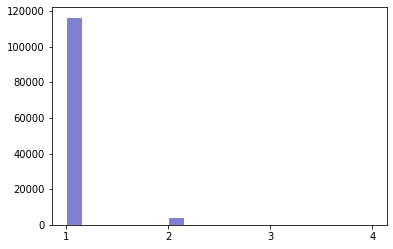

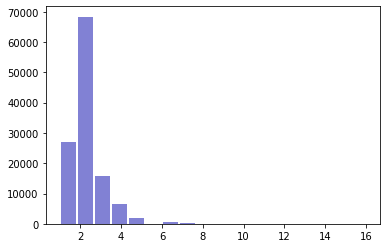

In [14]:
#######################################################################
## Histogram of n8k and nitem ########### much quicker in STATA #######
#######################################################################
n, bins, patches = plt.hist(crsp_comp_edgar['n8k'], bins='auto', color='#0504aa', alpha=0.5, rwidth=0.9)
plt.locator_params(axis='x', integer=True)
plt.show()
n, bins, patches = plt.hist(crsp_comp_edgar['nitem'], bins='auto', color='#0504aa', alpha=0.5, rwidth=0.9)
plt.locator_params(axis='x', integer=True)
plt.show()

In [18]:
############################################
########### Table: T2PC_before #############
############################################
item_before2004 = ['1','2','3','4','5','6','7','8','9','10','11','12']
item_before2004 = ['item_' + item for item in item_before2004]
item_after2004 = ['1.01','1.02','1.03','1.04', \
                  '2.01','2.02','2.03','2.04','2.05','2.06', \
                  '3.01','3.02','3.03', \
                  '4.01','4.02',
                  '5.01','5.02','5.03','5.04','5.05','5.06','5.07','5.08', \
                  '6.01','6.02','6.03','6.04','6.05', \
                  '7.01', \
                  '8.01', \
                  '9.01']
item_after2004 = ['item_' + item for item in item_after2004]
item  = item_before2004 + item_after2004

#crsp_comp_edgar = crsp_comp_edgar[crsp_comp_edgar['item_1'].notnull()]

n_item_before2004 = crsp_comp_edgar_ibes_seg.loc[:,item_before2004].sum().values.tolist()

nw_before = list()
n8k_before = list()
nitem_before = []
nexhibit_before = []
ngraph_before = []
TONE_before = list()
TLAG_before = list()
p_item_before = list()

for index, item in enumerate(item_before2004):
    p_appearance = n_item_before2004[index]/sum(n_item_before2004)
    p_item_before.append(p_appearance)
    
    nw_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['nw'].mean()
    nw_before.append(nw_mean)
    
    n8k_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['n8k'].mean()
    n8k_before.append(n8k_mean)
    
    nitem_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['nitem'].mean()
    nitem_before.append(nitem_mean)
    
    nexhibit_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['nexhibit'].mean()
    nexhibit_before.append(nexhibit_mean)
    
    ngraph_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['ngraph'].mean()
    ngraph_before.append(ngraph_mean)
    
    TONE_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['TONE'].mean()
    TONE_before.append(TONE_mean)
    
    TLAG_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['TLAG'].mean()
    TLAG_before.append(TLAG_mean)
    
############### Create Data Frame: T2PC_before
d = {'item': item_before2004, '# of appearance': n_item_before2004, '% of appearance': p_item_before, 'nw': nw_before, 'n8k': n8k_before, 'nitem': nitem_before, 'nexhibit': nexhibit_before, \
     'ngraph': ngraph_before, 'TONE': TONE_before, 'TLAG': TLAG_before}
T2PC_before = pd.DataFrame(data=d)

############# Save T2PC
table_path = '..\\output\\Tables.xlsx'
if os.path.exists(table_path) == True:
    book = load_workbook(table_path)
    writer = pd.ExcelWriter(table_path, engine = 'openpyxl')
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

    T2PC_before.to_excel(writer, sheet_name='T2PC_B_raw', float_format="%.4f", index=False)

    writer.save()
    writer.close()
    
else:
    T2PC_befoe.to_excel(table_path, sheet_name='T2PC_B_raw', float_format="%.4f", index=False)

T2PC_before

,item,# of appearance,% of appearance,nw,n8k,nitem,nexhibit,ngraph,TONE,TLAG
0,item_1,2712.0,0.083518,1075.972973,1.039245,3.481303,1.046649,0.473528,-1.013804,16.803776
1,item_2,4074.0,0.125462,7146.411634,1.038945,3.045847,1.590091,0.312546,-4.352871,21.642840
2,item_3,54.0,0.001663,12217.425926,1.111111,1.555556,1.740741,0.000000,-3.838710,28.425926
3,item_4,383.0,0.011795,1216.895561,1.028721,1.819843,0.950392,0.020888,-9.641813,23.509138
4,item_5,8909.0,0.274359,4272.151331,1.022215,1.813487,1.340776,0.103969,-2.937287,20.487821
5,item_6,34.0,0.001047,9247.323529,1.029412,2.205882,2.029412,0.058824,-9.339451,22.911765
6,item_7,10942.0,0.336967,5168.728851,1.020779,2.334134,1.579147,0.379202,-3.183399,20.455763
7,item_8,71.0,0.002186,6067.690141,1.014085,1.661972,1.633803,0.028169,-2.146166,29.422535
8,item_9,2966.0,0.091340,549.200815,1.036697,1.944275,1.099558,1.353721,-1.276898,15.999660
9,item_10,6.0,0.000185,289.000000,1.166667,3.500000,1.000000,7.166667,0.085198,27.000000


In [21]:
############################################
########### Table: T2PC_after ##############
############################################
# crsp_comp_edgar = crsp_comp_edgar[crsp_comp_edgar['item_1'].notnull()]

######### Group items into 9 subcategories
for i in list(range(1,10)):
    crsp_comp_edgar_ibes_seg['item_after_'+str(i)] = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg.columns[pd.Series(crsp_comp_edgar_ibes_seg.columns).str.startswith('item_'+str(i)+'.')]].sum(axis=1)

item_after2004 = list(range(1,10))
item_after2004 = ['item_after_' + str(item) for item in item_after2004] + ['item_2.02']

n_item_after2004 = crsp_comp_edgar_ibes_seg.loc[:,item_after2004].sum().values.tolist()

nw_after = list()
n8k_after = list()
nitem_after = []
nexhibit_after = []
ngraph_after = []
TONE_after = list()
TLAG_after = list()
p_item_after = list()

for index, item in enumerate(item_after2004):
    p_appearance = n_item_after2004[index]/sum(n_item_after2004[0:9])
    p_item_after.append(p_appearance)
    
    nw_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['nw'].mean()
    nw_after.append(nw_mean)
    
    n8k_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['n8k'].mean()
    n8k_after.append(n8k_mean)
    
    nitem_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['nitem'].mean()
    nitem_after.append(nitem_mean)
    
    nexhibit_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['nexhibit'].mean()
    nexhibit_after.append(nexhibit_mean)
    
    ngraph_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['ngraph'].mean()
    ngraph_after.append(ngraph_mean)
    
    TONE_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['TONE'].mean()
    TONE_after.append(TONE_mean)
    
    TLAG_mean = crsp_comp_edgar_ibes_seg[crsp_comp_edgar_ibes_seg[item]!=0]['TLAG'].mean()
    TLAG_after.append(TLAG_mean)
    
############### Create Data Frame: T2PC_after
d = {'item': item_after2004, '# of appearance': n_item_after2004, '% of appearance': p_item_after, 'nw': nw_after, 'n8k': n8k_after, 'nitem': nitem_after, 'nexhibit': nexhibit_after, \
     'ngraph': ngraph_after, 'TONE': TONE_after, 'TLAG': TLAG_after}
T2PC_after = pd.DataFrame(data=d)

############# Save T2PC
table_path = '..\\output\\Tables.xlsx'
if os.path.exists(table_path) == True:
    book = load_workbook(table_path)
    writer = pd.ExcelWriter(table_path, engine = 'openpyxl')
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

    T2PC_after.to_excel(writer, sheet_name='T2PC_A_raw', float_format="%.4f", index=False)

    writer.save()
    writer.close()
    
else:
    T2PC_befoe.to_excel(table_path, sheet_name='T2PC_A_raw', float_format="%.4f", index=False)

T2PC_after

,item,# of appearance,% of appearance,nw,n8k,nitem,nexhibit,ngraph,TONE,TLAG
0,item_after_1,10825.0,0.075768,839.480527,1.084035,2.849272,1.841443,1.479338,-3.441011,15.490437
1,item_after_2,31595.0,0.221144,463.042233,1.053947,2.410978,1.297098,2.190896,1.020697,12.518058
2,item_after_3,1728.0,0.012095,1128.684053,1.119305,3.686451,2.405276,1.916067,-4.259680,12.871703
3,item_after_4,478.0,0.003346,769.646186,1.086864,2.315678,1.186441,0.567797,-10.317334,16.381356
4,item_after_5,19494.0,0.136445,587.397345,1.063365,2.064733,0.959998,0.645279,0.088439,16.100974
5,item_after_6,2.0,0.000014,200.000000,1.000000,2.000000,1.000000,0.000000,2.202643,6.500000
6,item_after_7,11844.0,0.082900,561.761970,1.090552,2.651703,1.360075,8.974482,0.332962,11.260306
7,item_after_8,13009.0,0.091054,568.962842,1.088105,2.457973,1.384358,1.982083,-0.846727,12.145828
8,item_after_9,53896.0,0.377235,499.921288,1.047445,2.407730,1.393425,2.996424,0.494545,12.871032
9,item_2.02,27022.0,0.189136,404.172076,1.053303,2.286583,1.216848,2.279832,1.946144,12.105642
